In [1]:
from os.path import join, isfile, basename

from hydromt_wflow import WflowModel
from hydromt_sfincs import SfincsModel
from hydromt.config import configread
from hydromt.log import setuplog
import yaml

## Introduction

In this notebook we build a coupled Wflow - Sfincs model in two steps.

1. We setup the SFINCS model and automatically determine the locations where rivers flow into the model domain.  
2. We setup a Wflow model containing the catchments of the rivers flowing into the SFINCS model and add model output locations matching the SFINCS discharge boundary locations.

The models are build from global data sets which are shown below for both models.

## 1. Get data

We have saved the model input data in a zip file as part of the repository artifacts. The original data sources are saved in the data catalog yaml files which are contained in the zip archive. The meta data for the used data sources for each model from the data catalog files is shown below. 

In [2]:
# download the zip file from the zenodo and unzip it in the data folder
from data import copyfile
import shutil

version = "v1"
for model in ["wflow", "sfincs"]:
    src = f'https://zenodo.org/record/7858596/files/{model}_data.zip'
    dst = join("../data", basename(src))
    if not isfile(dst):
        copyfile(src, dst)
        shutil.unpack_archive(dst, "../data")

## 2. Build SFINCS model

In [3]:
# area of interest for the SFINCS model
bbox = [34.4, -20.05, 34.93, -19.45]

# initialize SfincsModel class 
sf = SfincsModel(
    root=r'../models/sfincs', # output dir
    mode='w+', # open in (over)write mode
    data_libs=[r'../data/sfincs_data/data_catalog.yml'],  # link to data catalog
    logger=setuplog('sfincs'), 
)

2023-11-28 13:44:26,981 - sfincs - log - INFO - HydroMT version: 0.9.1
2023-11-28 13:44:27,043 - sfincs - data_catalog - INFO - Parsing data catalog from ../data/sfincs_data/data_catalog.yml
2023-11-28 13:44:27,082 - sfincs - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\eilan_dk\project_data\hydromt-wflow-sfincs\models\sfincs\gis.
2023-11-28 13:44:27,084 - sfincs - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3.dev0).


In [4]:
# overview of data used for setting up the static SFINCS layers
sf_data = ['fabdem', 'merit_hydro', 'vito']
data_cols = ['category', 'paper_doi', 'paper_ref', 'source_url', 'source_version','source_license','notes']
sf.data_catalog.to_dataframe().loc[sf_data, data_cols]

,category,paper_doi,paper_ref,source_url,source_version,source_license,notes
name,,,,,,,
fabdem,topography,CC BY-NC-SA 4.0,Hawker et al. (2022),https://data.bris.ac.uk/data/dataset/25wfy0f9u...,1.0,CC BY-NC-SA 4.0,NaN
merit_hydro,topography,10.1029/2019WR024873,Yamazaki et al. (2019),http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_...,1.0,CC-BY-NC 4.0 or ODbL 1.0,NaN
vito,landuse,10.5281/zenodo.3939038,Buchhorn et al (2020),https://land.copernicus.eu/global/products/lc,v2.0.2,NaN,NaN


In [5]:
# inspect model building process
sf_config = configread('sfincs_build.yml')
print(sf_config.keys())

dict_keys(['setup_grid_from_region', 'setup_dep', 'setup_mask_active', 'setup_mask_bounds', 'setup_river_inflow', 'setup_river_outflow', 'setup_subgrid'])


In [6]:
sf.build(opt=sf_config,region={'bbox': bbox})

2023-11-28 13:44:27,695 - sfincs - model_api - INFO - setup_grid_from_region.region: {'bbox': [34.4, -20.05, 34.93, -19.45]}
2023-11-28 13:44:27,697 - sfincs - model_api - INFO - setup_grid_from_region.res: 150
2023-11-28 13:44:27,698 - sfincs - model_api - INFO - setup_grid_from_region.crs: utm
2023-11-28 13:44:27,700 - sfincs - model_api - INFO - setup_grid_from_region.rotated: True
2023-11-28 13:44:27,705 - sfincs - model_api - INFO - setup_grid_from_region.hydrography_fn: None
2023-11-28 13:44:27,708 - sfincs - model_api - INFO - setup_grid_from_region.basin_index_fn: None
2023-11-28 13:44:27,709 - sfincs - model_api - INFO - setup_grid_from_region.align: False
2023-11-28 13:44:27,711 - sfincs - model_api - INFO - setup_grid_from_region.dec_origin: 0
2023-11-28 13:44:27,712 - sfincs - model_api - INFO - setup_grid_from_region.dec_rotation: 3
2023-11-28 13:44:27,760 - sfincs - model_api - INFO - setup_dep.datasets_dep: [{'elevtn': 'fabdem', 'zmin': 0.001}, {'elevtn': 'merit_hydro', 

The nodata value None is not in the reclass table.None will be used for the params.


2023-11-28 13:44:34,811 - sfincs - subgrid - INFO - Number of regular cells in a block : 333
2023-11-28 13:44:34,812 - sfincs - subgrid - INFO - Number of blocks in n direction    : 2
2023-11-28 13:44:34,813 - sfincs - subgrid - INFO - Number of blocks in m direction    : 2
2023-11-28 13:44:34,814 - sfincs - subgrid - INFO - Grid size of flux grid            : dx=149.99999999999997, dy=149.99999999999895
2023-11-28 13:44:34,814 - sfincs - subgrid - INFO - Grid size of subgrid pixels       : dx=24.999999999999996, dy=24.999999999999826
2023-11-28 13:44:34,816 - sfincs - subgrid - INFO - block 1/4 -- col 0:332 | row 0:332
2023-11-28 13:44:51,257 - sfincs - subgrid - INFO - block 2/4 -- col 0:332 | row 333:442
2023-11-28 13:44:53,015 - sfincs - subgrid - INFO - block 3/4 -- col 333:371 | row 0:332
2023-11-28 13:44:53,671 - sfincs - subgrid - INFO - block 4/4 -- col 333:371 | row 333:442
2023-11-28 13:44:54,077 - sfincs - utils - INFO - Building 4 overviews with average
2023-11-28 13:44:54

NOTE that the steps above can also be done from the command line interface with

```
hydromt build sfincs ../models/sfincs -i sfincs_build.yml -r "{'bbox': [34.4,-20.05,34.93,-19.45]}" -d ../data/sfincs_data/data_catalog.yml -v --fo
```

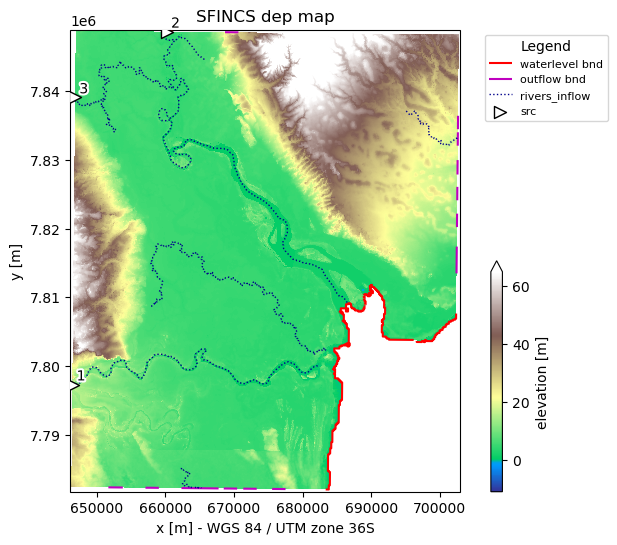

In [7]:
# plot the SFINCS dep map and boundaries 
sf.grid['dep'].attrs.update(long_name="elevation", units="m")
fig, ax = sf.plot_basemap(figsize=(8,6))
fig.savefig(join(sf.root, 'sfincs_basemap.png'), dpi=450, bbox_inches='tight')

## 3. Build Wflow model

In [8]:
# initialize WflowModel class model
wf = WflowModel(
    root = r'../models/wflow', # output dir
    mode='w+', # open in (over)write mode
    data_libs=[r'../data/wflow_data/data_catalog.yml'], # link to data catalog
    logger=setuplog('wflow'), 
)

2023-11-28 13:44:57,114 - wflow - log - INFO - HydroMT version: 0.9.1
2023-11-28 13:44:57,116 - wflow - data_catalog - INFO - Parsing data catalog from ../data/wflow_data/data_catalog.yml
2023-11-28 13:44:57,163 - wflow - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\eilan_dk\project_data\hydromt-wflow-sfincs\models\wflow\staticgeoms.
2023-11-28 13:44:57,166 - wflow - model_api - INFO - Initializing wflow model from hydromt_wflow (v0.4.1).
2023-11-28 13:44:57,167 - wflow - data_catalog - INFO - Parsing data catalog from c:\Users\eilan_dk\Miniconda3\envs\hydromt-wflow-sfincs\lib\site-packages\hydromt_wflow\data\parameters_data.yml


In [9]:
# overview of data used for setting up the static SFINCS layers
wf_data = ['merit_hydro_ihu', 'merit_hydro_ihu_index', 'rivers_lin2019_v1', 'hydro_reservoirs', 'hydro_lakes', 'soilgrids', 'modis_lai', 'globcover', 'vito']
wf.data_catalog.to_dataframe().loc[wf_data, data_cols]

,category,paper_doi,paper_ref,source_url,source_version,source_license,notes
name,,,,,,,
merit_hydro_ihu,topography,10.5194/hess-2020-582,Eilander et al. (2021),https://zenodo.org/record/5166932#.YVbxJ5pByUk,1.0,ODC-By 1.0,NaN
merit_hydro_ihu_index,topography,10.5194/hess-25-5287-2021,Eilander et al. (2021),NaN,NaN,CC-BY-NC 4.0,NaN
rivers_lin2019_v1,hydrography,10.5281/zenodo.3552776,Lin et al. (2019),https://zenodo.org/record/3552776#.YVbOrppByUk,1,CC-BY-NC 4.0,NaN
hydro_reservoirs,surface water,NaN,NaN,NaN,1.0,NaN,GRanD.v1.1_HydroLAKES.v10_JRC.2016
hydro_lakes,surface water,NaN,NaN,NaN,1.0,NaN,HydroLAKES.v10_extract
soilgrids,soil,10.1371/journal.pone.0169748,Hengl et al. (2017),https://www.isric.org/explore/soilgrids/faq-so...,2017,ODbL,soilthickness is based on 1) soilgrids (global...
modis_lai,landuse,10.5067/MODIS/MCD15A3H.006,Myneni et al (2015),https://lpdaac.usgs.gov/products/mcd15a3hv006/,MCD15A3H V006,https://lpdaac.usgs.gov/data/data-citation-and...,this dataset has been extracted from GEE ('MOD...
globcover,landuse,10.1594/PANGAEA.787668,Arino et al (2012),http://due.esrin.esa.int/page_globcover.php,v2.3,CC-BY-3.0,NaN
vito,landuse,10.5281/zenodo.3939038,Buchhorn et al (2020),https://land.copernicus.eu/global/products/lc,v2.0.2,NaN,NaN


### 2A Build base model

In [10]:
# read config file with step how to build the model
wf_config = configread('wflow_build.yml')
print(wf_config.keys())

dict_keys(['setup_basemaps', 'setup_rivers', 'setup_reservoirs', 'setup_lakes', 'setup_lulcmaps', 'setup_laimaps', 'setup_soilmaps', 'setup_constant_pars'])


In [11]:
# we add a setup gauges step to get output at the Sfincs model inflow locations
wf_config['setup_gauges'] = {
    'gauges_fn': join(sf.root, 'gis', 'src.geojson'),
    'snap_uparea': True, 
    'index_col': 'index',
    'basename': 'sfincs',
    'gauge_toml_header': ['Q'],  # save discharge only on these locations
    'gauge_toml_param': ['lateral.river.q_av'],
    'derive_subcatch': True,
}

In [12]:
# outlets: True to get rivers that have an oulet whithin the bbox (only for coastal regions)
wf.build(opt=wf_config,region={'basin': bbox, 'outlets': True})

# alternatively, you can provide a GeoDataFrame (or vector file) with the outlet locations to derive subbasins
# the uparea argument is added to snap the outlet locations to nearest downstream river
# gdf_src = sf.forcing['dis'].vector.to_gdf()
# region={'subbasin': gdf_src, 'uparea': gdf_src['uparea'].values.min()}

2023-11-28 13:44:57,323 - wflow - model_api - INFO - setup_basemaps.region: {'basin': [34.4, -20.05, 34.93, -19.45], 'outlets': True}
2023-11-28 13:44:57,325 - wflow - model_api - INFO - setup_basemaps.res: 0.00833
2023-11-28 13:44:57,326 - wflow - model_api - INFO - setup_basemaps.hydrography_fn: merit_hydro_ihu
2023-11-28 13:44:57,328 - wflow - model_api - INFO - setup_basemaps.basin_index_fn: merit_hydro_ihu_index
2023-11-28 13:44:57,329 - wflow - model_api - INFO - setup_basemaps.upscale_method: ihu
2023-11-28 13:44:57,331 - wflow - wflow - INFO - Preparing base hydrography basemaps.
2023-11-28 13:44:57,335 - wflow - rasterdataset - INFO - Reading merit_hydro_ihu raster data from c:\Users\eilan_dk\project_data\hydromt-wflow-sfincs\data\wflow_data\merit_hydro_ihu\{variable}.tif
2023-11-28 13:44:57,946 - wflow - basin_mask - INFO - basin bbox: [32.3750, -20.9417, 35.0000, -17.5250]
2023-11-28 13:44:59,995 - wflow - model_api - INFO - setup_rivers.hydrography_fn: merit_hydro_ihu
2023-

No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata


2023-11-28 13:46:30,336 - wflow - model_api - INFO - setup_constant_pars.dtype: float32
2023-11-28 13:46:30,338 - wflow - model_api - INFO - setup_constant_pars.nodata: -999
2023-11-28 13:46:30,338 - wflow - model_api - INFO - setup_constant_pars.KsatHorFrac: 100
2023-11-28 13:46:30,339 - wflow - model_api - INFO - setup_constant_pars.Cfmax: 3.75653
2023-11-28 13:46:30,340 - wflow - model_api - INFO - setup_constant_pars.cf_soil: 0.038
2023-11-28 13:46:30,341 - wflow - model_api - INFO - setup_constant_pars.EoverR: 0.11
2023-11-28 13:46:30,342 - wflow - model_api - INFO - setup_constant_pars.InfiltCapPath: 5
2023-11-28 13:46:30,342 - wflow - model_api - INFO - setup_constant_pars.InfiltCapSoil: 600
2023-11-28 13:46:30,343 - wflow - model_api - INFO - setup_constant_pars.MaxLeakage: 0
2023-11-28 13:46:30,344 - wflow - model_api - INFO - setup_constant_pars.rootdistpar: -500
2023-11-28 13:46:30,345 - wflow - model_api - INFO - setup_constant_pars.TT: 0
2023-11-28 13:46:30,345 - wflow - m

### 2B update static model layers based on different landuse

In [13]:
# update model with different landuse for a sensitivity analysis8

wf.setup_lulcmaps(
    lulc_fn='vito'
)
wf.setup_config(**{'input.path_static': 'staticmaps_vito.nc'})
wf.write_staticmaps()

2023-11-28 13:46:31,895 - wflow - wflow - INFO - Preparing LULC parameter maps.
2023-11-28 13:46:31,898 - wflow - rasterdataset - INFO - Reading vito raster data from c:\Users\eilan_dk\project_data\hydromt-wflow-sfincs\data\wflow_data\vito.tif
2023-11-28 13:46:31,942 - wflow - dataframe - INFO - Reading vito_mapping_default csv data from c:\Users\eilan_dk\Miniconda3\envs\hydromt-wflow-sfincs\lib\site-packages\hydromt_wflow\data\lulc\vito_mapping.csv
2023-11-28 13:46:32,022 - wflow - landuse - INFO - Deriving landuse using nearest resampling (nodata=0).
2023-11-28 13:46:33,398 - wflow - landuse - INFO - Deriving Kext using average resampling (nodata=-999.0).
2023-11-28 13:46:34,499 - wflow - landuse - INFO - Deriving N using average resampling (nodata=-999.0).
2023-11-28 13:46:35,622 - wflow - landuse - INFO - Deriving PathFrac using average resampling (nodata=-999.0).
2023-11-28 13:46:36,708 - wflow - landuse - INFO - Deriving RootingDepth using average resampling (nodata=-999.0).
2023

### 2C plot model base maps

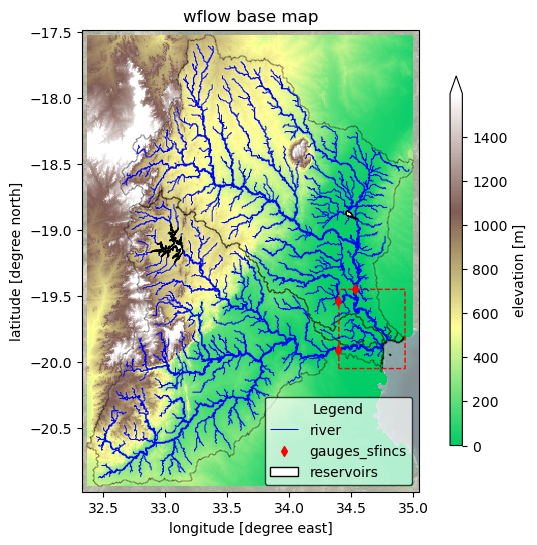

In [14]:
from wflow_utils import plot_basemap
# plot the wflow model
fig, ax = plot_basemap(wf, figsize=(8,6))
sf.grid.raster.box.to_crs(wf.crs).boundary.plot(ax=ax, color='r', lw=1, ls='--', label='SFINCS domain')
fig.savefig(join(wf.root, 'wflow_basemap.png'), dpi=450, bbox_inches='tight')